CIFAR Dataset with CNN


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [16]:
def get_data_loaders(batch_size=64):
  transform = transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
  ])
  train_set = torchvision.datasets.CIFAR10(root="./data", train=True, download=True, transform=transform)
  test_set = torchvision.datasets.CIFAR10(root="./data", train=False, download=True, transform=transform)

  train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=False)

  return train_loader, test_loader

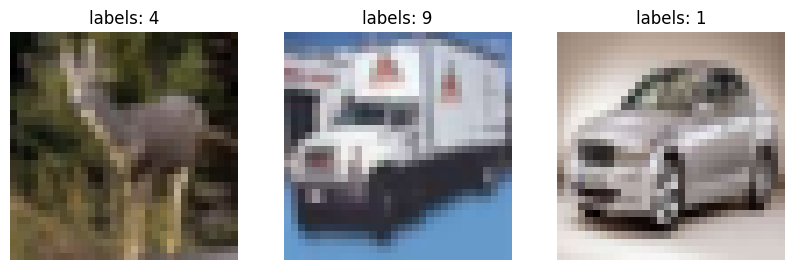

In [17]:
def imshow(img):
  # Reverse normalization for visualization
  img = img / 2 + 0.5
  np_img = img.numpy()
  # Transpose from (C, H, W) to (H, W, C)
  plt.imshow(np.transpose(np_img, (1, 2, 0)))

def get_sample_images(train_loader):
  data_iter = iter(train_loader)
  images, labels = next(data_iter)
  return images, labels

def visualize(n):
  train_loader, test_loader = get_data_loaders()
  images, labels = get_sample_images(train_loader)
  plt.figure(figsize=(10, 4))
  for i in range(n):
    plt.subplot(1, n, i + 1)
    imshow(images[i]) # Use helper to handle shape and normalization
    plt.title(f"labels: {labels[i]}")
    plt.axis("off")
  plt.show()

visualize(3)

In [22]:
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()

    #feature extraction
    self.conv1 = nn.Conv2d(3,32,kernel_size=3,padding=1) #input size (RGB), out_channel=32,kernel_size=3 padding=1
    self.relu = nn.ReLU()
    self.pool = nn.MaxPool2d(2,2) #kernel_size=2, stride=2
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1) #input and outputs should be compatible
    self.dropout = nn.Dropout(0.2)

    #fully connected layers
    self.fc1 = nn.Linear(64*8*8, 128) #image size is 8*8, input=64*8*8 output=128
    self.fc2 = nn.Linear(128,10) #output layer

  def forward(self,x):
    #flatten, fc, relu, dropout
    x = self.pool(self.relu(self.conv1(x)))
    x = self.pool(self.relu(self.conv2(x)))
    x = x.view(-1, 64*8*8) #-1 is deciding size
    x = self.dropout(self.relu(self.fc1(x)))
    x=self.fc2(x)

    return x

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN().to(device)

In [24]:
define_loss_and_optimizer = lambda model: (
    nn.CrossEntropyLoss(),
    optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
)

Epoch 1/10, Loss: 2.11380
Epoch 2/10, Loss: 1.72036
Epoch 3/10, Loss: 1.52075
Epoch 4/10, Loss: 1.40577
Epoch 5/10, Loss: 1.32442
Epoch 6/10, Loss: 1.26407
Epoch 7/10, Loss: 1.21188
Epoch 8/10, Loss: 1.16701
Epoch 9/10, Loss: 1.12767
Epoch 10/10, Loss: 1.08675


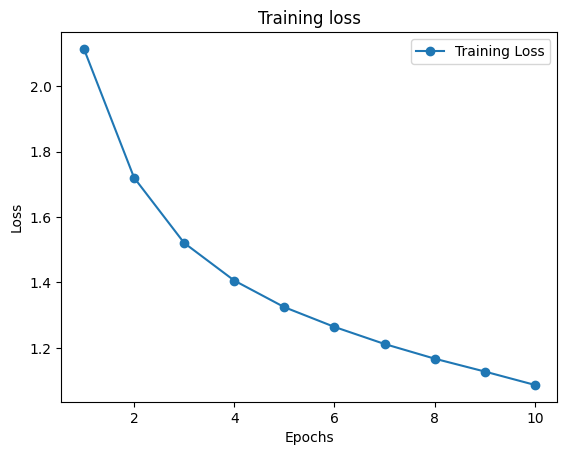

In [28]:
def train_model(model, train_loader, criterion, optimizer, epochs=5):
  model.train()
  train_loss = []
  for epoch in range(epochs):
    total_loss = 0
    for images, labels in train_loader:
      images, labels = images.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    train_loss.append(avg_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.5f}")

  plt.figure()
  plt.plot(range(1, epochs + 1), train_loss, marker="o", linestyle="-",label='Training Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training loss')
  plt.legend()
  plt.show()

train_loader, test_loader = get_data_loaders()
model = CNN().to(device)
criterion, optimizer = define_loss_and_optimizer(model)
train_model(model, train_loader, criterion, optimizer, epochs=10)

In [32]:
def test_model(model, test_loader, dataset_type):
  model.eval()
  correct = 0 #accurate pred count
  total = 0 #total pred

  with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)

      outputs = model(images) #prediction

      _, predicted= torch.max(outputs, 1) #highest prob class
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print(f"{dataset_type} accuracy: {100*correct/total}%")

test_model(model, test_loader, dataset_type="test")
test_model(model, train_loader, dataset_type="train")

test accuracy: 62.97%
train accuracy: 64.956%


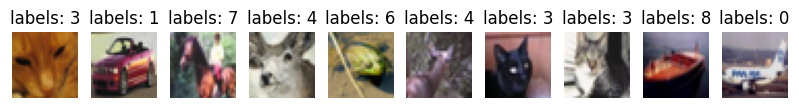

Epoch 1/10, Loss: 2.09872
Epoch 2/10, Loss: 1.73705
Epoch 3/10, Loss: 1.55271
Epoch 4/10, Loss: 1.43797
Epoch 5/10, Loss: 1.35062
Epoch 6/10, Loss: 1.28254
Epoch 7/10, Loss: 1.22888
Epoch 8/10, Loss: 1.17444
Epoch 9/10, Loss: 1.12741
Epoch 10/10, Loss: 1.08351


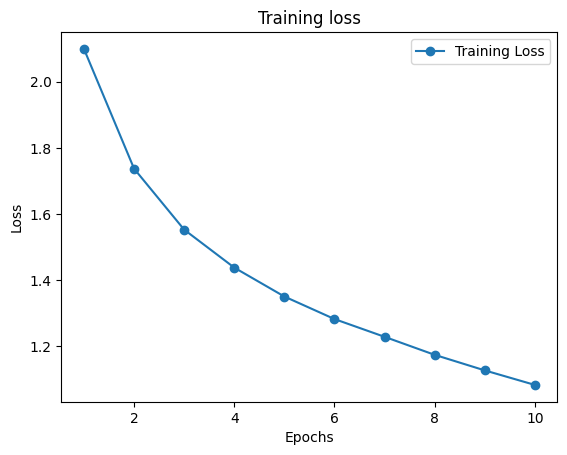

test accuracy: 62.36%
train accuracy: 64.994%


In [33]:
if __name__ == "__main__":
  train_loader, test_loader = get_data_loaders()

  visualize(10)

  model = CNN().to(device)

  criterion, optimizer = define_loss_and_optimizer(model)

  train_model(model, train_loader, criterion, optimizer, epochs=10)

  test_model(model, test_loader, dataset_type="test")
  test_model(model, train_loader, dataset_type="train")